# Binary catch

**При каких условиях два тела, налетающие друг на друга с бесконечности (в системе центра масс) станут связной системой из-за испускания гравволн?**

In [10]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];

ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",

    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]; *)
<<TensorSimplify`

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 3 Kb


## Einstein Summation

In [19]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
    transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [27]:
(* Правила для скрытия аргументов в TraditionalForm *)

Unprotect[Subscript, OverHat, Derivative];

MakeBoxes[OverHat[r_][OverHat[t]], TraditionalForm] :=
  MakeBoxes[OverHat[r], TraditionalForm]

MakeBoxes[\[Phi][OverHat[t]], TraditionalForm] :=
  MakeBoxes[\[Phi], TraditionalForm]

MakeBoxes[Subscript[OverHat[r], n_][OverHat[t]], TraditionalForm] :=
  SubscriptBox[OverscriptBox["r", "^"], ToString[n]];

MakeBoxes[OverHat[\[Omega]][OverHat[t]], TraditionalForm] :=
  OverscriptBox["\[Omega]", "^"];

MakeBoxes[Derivative[n_][f_][OverHat[t]], TraditionalForm] := Module[{primes},
  primes = StringJoin[Table["\[Prime]", n]];
  SuperscriptBox[ToBoxes[f], primes]
];

Protect[Subscript, OverHat, Derivative];

$\hat{r}_k$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"cos", "(", "ϕ", ")"}]}]}, 

 
>            {RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
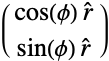

In [36]:
rh = {OverHat[r][OverHat[t]]*Cos[\[Phi][OverHat[t]]], OverHat[r][OverHat[t]]*Sin[\[Phi][OverHat[t]]]};
rh // MatrixForm // TraditionalForm

In [37]:
$Assumptions = {
  {OverHat[r][OverHat[t]], OverHat[t], rh, Subscript[OverHat[r],2][OverHat[t]]} \[Element] PositiveReals
};

## Система движения в декартовых координатах
$$
\frac{d^2r_k}{dt^2} = -\frac{G(m_A+m_B)}{r^3}r_k - \frac{2}{5}f_{ki}^{(5)}r_i
$$

Ч.Мизнер, К.Торн, Дж.Уилер Гравтация, Т.3 (36.8)

Введём обозначения для масс

$$
M=m_A+m_B; \quad
\mu = m_{AB} = \frac{m_A m_B}{M}
$$

### Безразмерные единицы
$$
\begin{align}
r &= b\hat{r} \\
t &= t_0\hat{t} \\
f_{ij} &= b^2\frac{G}{c^5}\mu\hat{f}_{ij} \\
f_{ij}^{(5)} &= \frac{b^2}{t_0^5}\frac{G}{c^5}\mu\hat{f}_{ij}^{(5)}
\end{align}
$$

$\hat{f}_{ki}$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{RowBox[{FractionBox["1", "6"], " ", 

 
>              SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"3", " ", 

 
>                    RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}]}], "+",\
 
>    "1"}]\
, ")"}]}], RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"sin", "(", "ϕ", ")"}], " ", RowBox[{"cos", "(", "ϕ", ")"}]}]}, 

 
>           {RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"sin", "(", "ϕ", ")"}], " ", RowBox[{"cos", "(", "ϕ", ")"}]}], 

 
>            RowBox[{FractionBox["1", "3"], " ", 

 
>              SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"3", " ", 

 
>                    RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}]}], "-", "1"}], 

 
>                ")"}]}]}}, Rule[RowSpacings, 1], Rule[ColumnSpacings, 1], 

 
>          Rule[RowAlignments, Baseline], Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
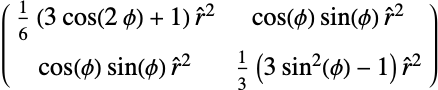

In [39]:
fh = Simplify[Array[rh[[#]]*rh[[#2]] - 1/3*KroneckerDelta[#, #2]*(OverHat[r][OverHat[t]])^2 &, {2, 2}], Trig -> True];
fh // MatrixForm // TraditionalForm

$\hat{f}_{ki}^{(5)}$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]], 

 
>            TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]]}, 

 
>           {TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]], 

 
>            TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
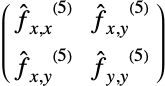

In [43]:
(* fh5 = Array[Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"] &, {2, 2}] *)
(* Symmetric version *)
fh5 = Array[If[#1 <= #2,
                    Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"],
                    Superscript[Subscript[OverHat[f], {x, y}[[#2]], {x, y}[[#1]]], "(5)"]] &, {2, 2}];
fh5 // MatrixForm // TraditionalForm

$\hat{f}_{ki}^{(5)}\hat{r}_i$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                 TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"cos", "(", "ϕ", ")"}], 

 
>                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}]}]}, 

 
>            {RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                 TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}], 

 
>                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}]}]}}, Rule[RowSpacings, 1], 

 
>           Rule[ColumnAlignments, Center], Rule[ColumnAlignments, Left]], Column], "⁠",\
 
>    
      ")"}], Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
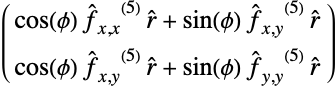

In [45]:
fh5rh = EinsteinSummation[{{k, i}, {i}}, {fh5, rh}];
fh5rh // MatrixForm // TraditionalForm

Система движения в безразмерной записи будет выглядеть как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} = -\frac{t_0^2}{b^3}\frac{GM}{\hat{r}^3}\hat{r}_k - \frac{2}{5}\frac{b^2}{t_0^3}\frac{G}{c^5}\mu\hat{f}_{ki}^{(5)}\hat{r}_i
$$

Пусть $t_0 = \sqrt{\frac{b^3}{GM}}$, а $b$ - прицельное расстояние, тогда система движения перепишется как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} + \frac{\hat{r}_k}{\hat{r}^3} = - \epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$
или
$$
\hat{r}_k^{(2)} + \frac{\hat{r}_k}{\hat{r}^3} = - \epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$

где безразмерная постоянная $\epsilon_G = \frac{2}{5}\frac{b^2}{t_0^3}\frac{G}{c^5}\mu = \frac{2}{5}\frac{\mu}{M} \left( \frac{GM}{bc^2} \right)^{\frac{5}{2}}$.

Заметим , что $f_{ij}^{(5)} = \frac{5}{2}\frac{\epsilon_G}{t_0^2}\hat{f}_{ij}^{(5)}$

## Повернём систему с помощью матрицы вращения $R_{ij}(\phi)$ на угол $\phi$ по **часовой** стрелке
Переход к полярным координатам от декартовых

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{RowBox[{"cos", "(", "ϕ", ")"}], RowBox[{"sin", "(", "ϕ", ")"}]}, 

 
>           {RowBox[{"-", RowBox[{"sin", "(", "ϕ", ")"}]}], 

 
>            RowBox[{"cos", "(", "ϕ", ")"}]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
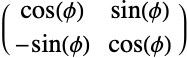

In [46]:
RotationMatrix[-\[Phi]] // MatrixForm // TraditionalForm

#### LHS системы после поворота

FormBox[TagBox[RowBox[{"(", "⁠", 
      TagBox[GridBox[{{RowBox[{RowBox[{"-", 

 
>                 RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                   " ", SuperscriptBox["ϕ", "′"], " ", 

 
>                   RowBox[{"sin", "(", "ϕ", ")"}]}]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"(", RowBox[{RowBox[{SuperscriptBox[RowBox[

 
>                         {"(", SuperscriptBox["ϕ", "′"], ")"}], "2"], " ", 

 
>                       RowBox[{"(", 

 
>                         RowBox[{"-", RowBox[{"cos", "(", "ϕ", ")"}]}], ")"}]}], 

 
>                     "-", RowBox[{SuperscriptBox["ϕ", "′′"], " ", 

 
>                       RowBox[{"sin", "(", "ϕ", ")"}]}]}], ")"}]}], "+", 

 
>               RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′′"], " ", 

 
>                 RowBox[{"cos", "(", "ϕ", ")"}]}], "+", 

 
>               FractionBox[RowBox[{"cos", "(", "ϕ", ")"}], 

 
>                SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}, 

 
>            {RowBox[{RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                 " ", SuperscriptBox["ϕ", "′"], " ", RowBox[{"cos", "(", "ϕ",\
 
>    ")"}]}]\
, "+", RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"(", RowBox[{RowBox[{SuperscriptBox["ϕ", "′′"], " ", 

 
>                       RowBox[{"cos", "(", "ϕ", ")"}]}], "-", 

 
>                     RowBox[{SuperscriptBox[RowBox[{"(", 

 
>                          SuperscriptBox["ϕ", "′"], ")"}], "2"], " ", 

 
>                       RowBox[{"sin", "(", "ϕ", ")"}]}]}], ")"}]}], "+", 

 
>               RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′′"], " ", 

 
>                 RowBox[{"sin", "(", "ϕ", ")"}]}], "+", 

 
>               FractionBox[RowBox[{"sin", "(", "ϕ", ")"}], 

 
>                SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
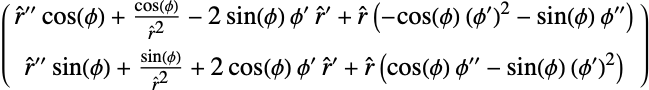

In [48]:
LHSMotion = D[rh, {OverHat[t], 2}] + Simplify[rh / Norm[rh]^3];
LHSMotion // MatrixForm // TraditionalForm

FormBox[TagBox[RowBox[{"(", "⁠", 
      TagBox[GridBox[{{RowBox[{RowBox[{"-", 

 
>                 RowBox[{RowBox[{OverscriptBox["r", "^"]}], " ", 

 
>                   SuperscriptBox[RowBox[{"(", SuperscriptBox["ϕ", "′"], ")"}], 

 
>                    "2"]}]}], "+", SuperscriptBox[OverscriptBox["r", "^"], "′′"], 

 
>               "+", FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"],\
 
>    "2"]]}]}\
, {RowBox[{RowBox[{OverscriptBox["r", "^"], " ", SuperscriptBox["ϕ",\
 
>    "′′"]}], "+", 
            RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r",\
 
>    "^"], "′"], " ", 
              SuperscriptBox["ϕ", "′"]}]}]}}, Rule[RowSpacings,\
 
>    1], 
        Rule[ColumnAlignments, Center], Rule[ColumnAlignments, Left]],\
 
>    Column], "⁠", 
      ")"}], Function[BoxForm`e$, MatrixForm[BoxForm`e$]]],\
 
>    TraditionalForm]
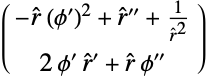

In [49]:
RotatedLHSMotion = Simplify[RotationMatrix[-\[Phi][OverHat[t]]] . LHSMotion, Trig -> True] // MatrixForm // TraditionalForm

Так как $\hat{\omega} \equiv \phi^{(1)}$, то

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{RowBox[{RowBox[{"-", OverscriptBox["r", "^"]}], 

 
>                 " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"]}], "+", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "′′"], "+", 

 
>               FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}, 

 
>            {RowBox[{RowBox[{"2", " ", OverscriptBox["ω", "^"], " ", 

 
>                 SuperscriptBox[OverscriptBox["r", "^"], "′"]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
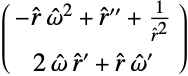

In [51]:
OmegaReplace = Derivative[n_][\[Phi]][OverHat[t]] :> Derivative[n-1][OverHat[\[Omega]]][OverHat[t]];

OmegaLHSMotion = RotatedLHSMotion /. OmegaReplace // TraditionalForm

### RHS системы после поворота

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                   RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", "ϕ", ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                   RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               OverscriptBox["r", "^"], " ", SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
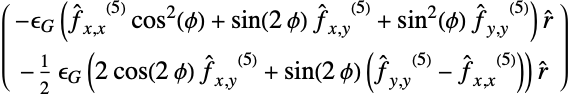

In [53]:
RHSMotion = -Subscript[\[Epsilon], G] FullSimplify[RotationMatrix[-\[Phi][OverHat[t]]] . fh5rh, Trig -> True];
RHSMotion // MatrixForm // TraditionalForm

<span style="color:red">**NB:**</span> Полученные выражения <span style="color:green">**совпадают**</span> с уравнениями (10) и (9) из файла Binary.pdf

## Получим теперь **энергетическую** систему уравнений

В задача двух тел без учёта гравитационного излучения в системе центра масс в полярных координатах радиус-вектор $\hat{r}_k$ задаётся как:
$$
\hat{r}_k = \hat{r} e_{1k} \quad,
$$
где:
- $\hat{r}$ — расстояние между телами,
- $e_{1k}$ — единичный вектор в направлении $\hat{r}_k$.

Скорость в полярных координатах выражается как:
$$
\hat{r}_k^{(1)} = \hat{r}^{(1)} e_{1k} + \hat{r} \phi^{(1)} e_{2k} \quad,
$$
где:
- $\hat{r}^{(1)}$ — радиальная скорость
- $\hat{\omega} \equiv \phi^{(1)}$ — угловая скорость
- $e_{2k}$ — единичный вектор, перпендикулярный $e_{1k}$.

### **Кинетическая энергия**
Кинетическая энергия $T$ в полярных координатах выражается через радиальную и тангенциальную составляющие скорости:
$$
T = \mu\frac{b^2}{2 t_0^2} (\hat{r}_k^{(1)})^2 = \mu\frac{b^2}{2 t_0^2} \left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) = \frac{G \mu M}{b} \frac{1}{2}\left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right)
$$

### **Потенциальная энергия**
Потенциальная энергия $U$ зависит только от расстояния $\hat{r}$:
- Для гравитационного взаимодействия:
  $$
  U = -\frac{G m_A m_B}{b \hat{r}} = -\frac{G \mu M}{b \hat{r}}.
  $$

### **Полная энергия**
Полная энергия $E$ в полярных координатах:
$$
E = T + U = \frac{G \mu M}{b}\left(\frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}\right) = \frac{G \mu M}{b} \hat{E}
$$

Здесь $\hat{E}$ - безразмерная энергия:

FormBox[RowBox[{RowBox[{FractionBox["1", "2"], " ", 

 
>          SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>          SuperscriptBox[OverscriptBox["ω", "^"], "2"]}], "+", 

 
>        RowBox[{FractionBox["1", "2"], " ", 

 
>          SuperscriptBox[RowBox[{"(", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>             ")"}], "2"]}], "-", FractionBox["1", OverscriptBox["r", "^"]]}], 

 
>      TraditionalForm]
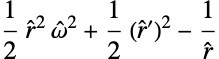

In [55]:
Energy = (D[OverHat[r][OverHat[t]], OverHat[t]])^2/2 + (OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]])^2/2 - 1/OverHat[r][OverHat[t]];
Energy // TraditionalForm

### **Момента импульса**
Момент импульса $J$ в системе центра масс:
$$
J = \mu\frac{b^2}{t_0} \hat{r}^2 \hat{\omega} = \mu(G M)^{1/2} b^{3/2} \hat{r}^2 \hat{\omega} = \mu(G M)^{1/2} b^{3/2} \hat{J}
$$

Здесь $\hat{J}$ - безразмерный момент импульса:

In [57]:
AngularMomentum = (OverHat[r][OverHat[t]])^2 OverHat[\[Omega]][OverHat[t]];
AngularMomentum // TraditionalForm

FormBox[RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>        OverscriptBox["ω", "^"]}], TraditionalForm]

Отсюда $\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat{\omega} \frac{d\hat{J}}{d\hat{t}}\right)$

FormBox[RowBox[{RowBox[{"-", RowBox[{RowBox[{OverscriptBox["r", "^"]}], " ", 

 
>            SuperscriptBox[OverscriptBox["ω", "^"], "2"]}]}], "+", 

 
>        SuperscriptBox[OverscriptBox["r", "^"], "′′"], "+", 

 
>        FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    TraditionalForm]
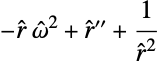

In [58]:
Simplify[(D[Energy, OverHat[t]] - (AngularMomentum/OverHat[r][OverHat[t]]^2)(D[AngularMomentum, OverHat[t]]))/(D[OverHat[r][OverHat[t]], OverHat[t]])] // TraditionalForm

Что совпадает с **первой** строкой повернутой LHS системы движения

Отсюда $\frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}}$

In [59]:
Simplify[D[AngularMomentum, OverHat[t]]/OverHat[r][OverHat[t]]] // TraditionalForm

FormBox[RowBox[{RowBox[{"2", " ", OverscriptBox["ω", "^"], " ", 

 
>          SuperscriptBox[OverscriptBox["r", "^"], "′"]}], "+", 

 
>        RowBox[{OverscriptBox["r", "^"], " ", 

 
>          SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}], TraditionalForm]

Что совпадает со **второй** строкой повернутой LHS системы движения

Таким образом, мы можем выписать новую **энергетическую** систему уравнений

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \epsilon_G \left(\hat{r}^{(1)} R_{xi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j + \hat{r}\hat\omega R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j \right)
\\
\frac{d\hat{J}}{d\hat{t}} &= - \epsilon_G \hat{r} R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j
\end{align}
$$

Или

$$
\left(\frac{d\hat{E}}{d\hat{t}}, \frac{d\hat{J}}{d\hat{t}}\right) = - \epsilon_G T_{nk} R_{ki}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j\quad,
$$

Чтобы перейти в размерный вид, достаточно положить $\epsilon_G \equiv \frac{2}{5}\mu$.

Здесь
$$
T = 
\begin{bmatrix}
\hat{r}^{(1)} & \hat{r}\hat{\omega} \\
0 & \hat{r}
\end{bmatrix}
$$
матрица трансформации:

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>            RowBox[{OverscriptBox["r", "^"], " ", OverscriptBox["ω", "^"]}]}, 

 
>           {"0", OverscriptBox["r", "^"]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
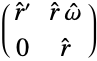

In [61]:
Transform = {{D[OverHat[r][OverHat[t]], OverHat[t]], OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]]}, {0, OverHat[r][OverHat[t]]}};
Transform // MatrixForm // TraditionalForm

Итак правая часть энергетической системы запишется как

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{FractionBox["1", "2"], " ", 

 
>               OverscriptBox["r", "^"], " ", SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                     OverscriptBox["ω", "^"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           RowBox[{"(", 

 
>                             RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                             "Superscript", Rule[SyntaxForm, SuperscriptBox]], 

 
>                             "-", 

 
>                             TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                             Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}], "-", 

 
>                         RowBox[{"2", " ", 

 
>                           RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                           " ", TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                            Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], "-", 

 
>                   RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                     " ", RowBox[{"(", 

 
>                       RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}]}], 

 
>                       ")"}]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>       
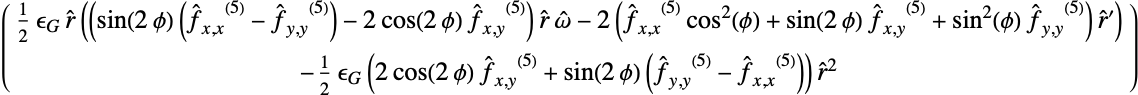

In [63]:
RHSEnegry = FullSimplify[Transform . RHSMotion, Trig -> True];
RHSEnegry // MatrixForm // TraditionalForm

## Другой Способ получения уравнений движения и энергетических уравнений через лагранжев формализм в полярных координатах

### **Лагранжиан системы**
Лагранжиан $L$ в полярных координатах $(r, \phi)$ выражается как:
$$
L = T - (U + \mu\Phi),
$$
где:
- $T$ — кинетическая энергия,
- $U$ — потенциальная энергия
- $\Phi = \frac{1}{5}f_{ij}^{(5)}r_i r_j = \frac{\epsilon_G}{2}\frac{b^2}{t_0^2}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j = \frac{5}{2}\epsilon_G\frac{GM}{b}\hat{\Phi}$ - малый потенциал "реакции излучения"

Безразмерный малый потенциал "реакции излучения" $\hat{\Phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\hat{r}_i\hat{r}_j$

FormBox[RowBox[{FractionBox["1", "5"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>              RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                  RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], "+", 

 
>            RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                  RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}],\
 
>    
                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}], ")"}]}], 

 
>      TraditionalForm]
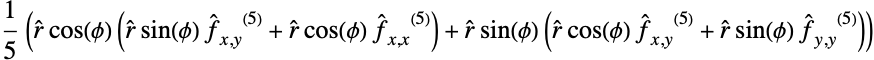

In [65]:
fh5rhrh = 1/5 EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, rh}];
fh5rhrh // TraditionalForm

Безразмерный лагранжиан

$$
\hat{L} = \hat{T} - (\hat{U} + \frac{5}{2}\epsilon_G\hat{\Phi}),
$$
или
$$
\hat{L} = \frac{1}{2} \left((\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) + \frac{1}{\hat{r}} - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j.
$$

### **Уравнения Эйлера-Лагранжа**
Уравнения Эйлера-Лагранжа имеют вид:
$$
\frac{d}{dt} \left( \frac{\partial \hat{L}}{\partial \dot{q}_i} \right) - \frac{\partial \hat{L}}{\partial q_i} = 0,
$$
где $q_i$ — обобщённые координаты ($\hat{r}$ и $\phi$).

---

#### Уравнение для координаты $\hat{r}$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) - \frac{\partial \hat{L}}{\partial \hat{r}} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} = \hat{r}^{(1)}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) = \hat{r}^{(2)},
$$
$$
\frac{\partial \hat{L}}{\partial \hat{r}} = \hat{r} \hat{\omega}^2 - \frac{1}{\hat{r}^2} - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$

Это **радиальное уравнение движения**.

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \hat{r}} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \hat{r}}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \hat{r}}\right)
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\hat{r}$ при вариации лагранжиана.

Правая часть радиального уравнения движения будет выглядеть как

FormBox[RowBox[{OverscriptBox["r", "^"], " ", 

 
>        RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", RowBox[{"2", " ", "ϕ"}], 

 
>                ")"}], " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>            RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", "ϕ", ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>            RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], TraditionalForm]
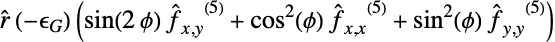

In [67]:
RHSMotionRadialLagrange = - 1/2 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, OverHat[r][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, OverHat[r][OverHat[t]]]}]];
RHSMotionRadialLagrange // TraditionalForm

<span style="color:red">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (10) из файла Binary.pdf

In [68]:
RHSMotion[[1]] - RHSMotionRadialLagrange

0

---

#### Уравнение для координаты $\phi$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{\omega}} \right) - \frac{\partial \hat{L}}{\partial \phi} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{\omega}} = \hat{r}^2 \hat{\omega}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{\omega}} \right) = \frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right),
$$
$$
\frac{\partial \hat{L}}{\partial \phi} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\frac{1}{\hat{r}}\frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right) = \frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}} = - \frac{5}{2}\frac{\epsilon_G}{\hat{r}}\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\phi$ при вариации лагранжиана.

Правая часть уравнения движения для $\phi$ будет выглядеть как

FormBox[RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", OverscriptBox["r", "^"], 

 
>        " ", SubscriptBox["ϵ", "G"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", RowBox[{"2", " ", "ϕ"}], 

 
>                ")"}], " ", RowBox[{"(", 

 
>                RowBox[{TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                  TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}], "+", 

 
>            RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], TraditionalForm]
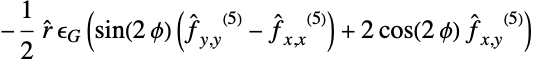

In [70]:
RHSMotionPhiLagrange = - 1/2 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, \[Phi][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, \[Phi][OverHat[t]]]}]]/OverHat[r][OverHat[t]];
RHSMotionPhiLagrange // TraditionalForm

<span style="color:red">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (9) из файла Binary.pdf

In [71]:
RHSMotion[[2]] - RHSMotionPhiLagrange

0

## Получим **энергетическую** систему уравнений в подходе Лагранжа

Заметим, что энергия системы:
$$
\hat{E} = \frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}
$$
$$
\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat{\omega} \frac{d\hat{J}}{d\hat{t}}\right) = \hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2}
$$

А также уравнение для изменения момента импульса системы есть
$$
\frac{d\hat{J}}{d\hat{t}} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Итоговая энергетическая система, выведенная по-новому будет записываться как:

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \frac{5}{2}\epsilon_G\left(\hat{r}^{(1)}\frac{\partial \hat{\Phi}}{\partial \hat{r}} + \hat{\omega} \frac{\partial \hat{\Phi}}{\partial \phi}\right) = - \frac{5}{2}\epsilon_G \frac{d\hat{\Phi}}{d\hat{t}}
  = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\left(\frac{d\hat{r}_i}{d\hat{t}}\hat{r}_j + \hat{r}_i\frac{d\hat{r}_j}{d\hat{t}}\right)
\\
\frac{d\hat{J}}{d\hat{t}} &= - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi} = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
\end{align}
$$

И снова, чтобы перейти в размерный вид, достаточно положить $\epsilon_G \equiv \frac{2}{5}\mu$

То есть
$$
\begin{align}
\frac{dE}{dt} &= - \mu\frac{d\Phi}{dt}
\\
\frac{dJ}{dt} &= - \mu\frac{\partial \Phi}{\partial \phi}
\end{align}
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\hat{r}, \phi, \hat{t}$ при вариации лагранжиана.

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                     OverscriptBox["ω", "^"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"cos", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                           RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                           RowBox[{"(", 

 
>                             RowBox[{TemplateBox[List[SubscriptBox[

 
>                             OverscriptBox["f", "^"], 

 
>                             RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                             "Superscript", Rule[SyntaxForm, SuperscriptBox]], 

 
>                              "-", 

 
>                              TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                              Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}]}], ")"}]\

 
>   }], "+", RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}]}], 

 
>                       ")"}]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>           Rule[
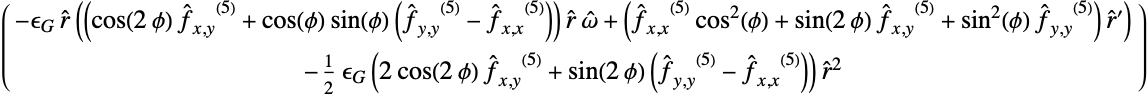

In [73]:
RHSEnegryLagrange = - 5/2 Subscript[\[Epsilon],G] FullSimplify[{
  D[fh5rhrh, OverHat[t]] /. OmegaReplace,
  D[fh5rhrh, \[Phi][OverHat[t]]]
}, Trig -> True];

RHSEnegryLagrange // MatrixForm // TraditionalForm

<span style="color:red">**NB:**</span> Выражения полностью <span style="color:green">**совпадают**</span> с предыдущим подходом!

0

0
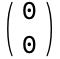

In [74]:
FullSimplify[RHSEnegryLagrange - RHSEnegry] // MatrixForm

In [75]:
TeXForm[RHSEnegryLagrange]

\left\{\hat{r} \left(-\epsilon _G\right) \left(\hat{r} \hat{\omega } \left(\cos (2 \phi\
 
>   ) \hat{f}_{x,y}{}^{\text{(5)}}+\sin (\phi ) \cos (\phi )\
 
>   \left(\hat{f}_{y,y}{}^{\text{(5)}}-\hat{f}_{x,x}{}^{\text{(5)}}\right)\right)+\hat{r\
 
>   }' \left(\sin (2 \phi ) \hat{f}_{x,y}{}^{\text{(5)}}+\cos ^2(\phi )\
 
>   \hat{f}_{x,x}{}^{\text{(5)}}+\sin ^2(\phi )\
 
>   \hat{f}_{y,y}{}^{\text{(5)}}\right)\right),-\frac{1}{2} \hat{r}^2 \epsilon _G\
 
>   \left(\sin (2 \phi )\
 
>   \left(\hat{f}_{y,y}{}^{\text{(5)}}-\hat{f}_{x,x}{}^{\text{(5)}}\right)+2 \cos (2\
 
>   \phi ) \hat{f}_{x,y}{}^{\text{(5)}}\right)\right\}

# Итоговая система **энергетических** уравнений:

$$
\begin{align}
\tag{dJ/dt}
\frac{d\hat{J}}{d\hat{t}} &= -\frac{1}{2} \epsilon_G
\hat{r}^2
\left(
  \sin (2 \phi ) \left(\hat{f}_{y,y}{}^{\text{(5)}}-\hat{f}_{x,x}{}^{\text{(5)}}\right)+2 \cos (2 \phi ) \hat{f}_{x,y}{}^{\text{(5)}}
\right)
= \epsilon_G I_J
\\
\tag{dE/dt}
\frac{d\hat{E}}{d\hat{t}} &= \epsilon_G
\left(
  I_J\hat{\omega}
  -\hat{r} \hat{r}'
  \left(
  \sin (2 \phi ) \hat{f}_{x,y}{}^{\text{(5)}}+\cos ^2(\phi ) \hat{f}_{x,x}{}^{\text{(5)}}+\sin ^2(\phi ) \hat{f}_{y,y}{}^{\text{(5)}}
  \right)
\right)
= \epsilon_G I_E
\end{align}
$$

# RHS уравнения (dJ/dt)

Введём новое обозначение $\hat{r}^2 \equiv \hat{r}_2$

In [76]:
ToR2Replacement = {
  OverHat[r][OverHat[t]] -> Sqrt[Subscript[OverHat[r],2][OverHat[t]]],
  Derivative[n_][OverHat[r]][OverHat[t]] :> D[Sqrt[Subscript[OverHat[r], 2][OverHat[t]]], {OverHat[t], n}]
};

и подставим в (dJ/dt) значения $\hat{f}_{i,j}^{(5)}$:

FormBox[RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{"-", 

 
>              RowBox[{"5", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                  "2"], "′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′′′"]}]}], 

 
>            "-", RowBox[{"10", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", 

 
>                 "^"], "2"], "′′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"],\
 
>    "′"]}]\
, "+", RowBox[{"120", " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"], "\
 
>    ", 
           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], "\
 
>    ", 
           SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>            RowBox[{"60", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              OverscriptBox["ω", "^"], " ", 
           SuperscriptBox[RowBox[{"(", 

 
>                 SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], "+", 

 
>            RowBox[{"40", " ", SuperscriptBox[OverscriptBox["ω", "^"], "3"], " ", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"]}], "+", 

 
>            RowBox[{"40", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "-", 

 
>            RowBox[{"10", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                "2"], "′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "-",\
 
>    
         RowBox[{"5", " ", OverscriptBox["ω", "^"], " ", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′′"]}],\
 
>    "-", 
         RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "′′′′"]}], "-", 

 
>            RowBox[{RowBox[{"16"}], " ", SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>              " ", SuperscriptBox[OverscriptBox["ω", "^"], "5"]}]}], ")"}]}], 

 
>      TraditionalForm]
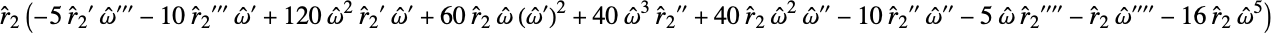

In [82]:
fh1 = fh /. ToR2Replacement;
fh5Symbolic = Simplify[D[fh1, {OverHat[t], 5}], Trig -> True];

Fh5Replacement = Flatten[{
  Outer[
    Superscript[Subscript[OverHat[f], #1, #2], "(5)"] -> fh5Symbolic[[#1 /. {x -> 1, y -> 2}, #2 /. {x -> 1, y -> 2}]] &,
    {x, y}, {x, y}
  ],
  ToR2Replacement,
  OmegaReplace
}];

dJdtTemp = RHSEnegryLagrange[[2]] //. Fh5Replacement;
dJdt = Subscript[OverHat[r],2][OverHat[t]]*Expand[Simplify[dJdtTemp/Subscript[\[Epsilon], G], Trig -> True]/Subscript[OverHat[r],2][OverHat[t]]];
dJdt // TraditionalForm

<span style="color:red">**NB:**</span> В файле Binary.pdf выводится <span style="color:green">**точно такое же**</span> выражение

$$
I_J = I_1 = \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\hat{\omega}^2\hat{\omega}^{(1)} - 5\hat{r}_2^{(1)}\hat{\omega}^{(3)} - 16\hat{r}_2\hat{\omega}^5 - 10\hat{r}_2^{(2)}\hat{\omega}^{(2)} + 60\hat{r}_2\hat{\omega}(\hat{\omega}^{(1)})^2
- 10\hat{r}_2^{(3)}\hat{\omega}^{(1)} + 40\hat{r}_2^{(2)}\hat{\omega}^3 - 5\hat{r}_2^{(4)}\hat{\omega} - \hat{r}_2\hat{\omega}^{(4)} + 40\hat{r}_2\hat{\omega}^2\hat{\omega}^{(2)} \right]
$$

In [84]:
I1 = Subscript[OverHat[r], 2][OverHat[t]] * (
    120 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^2 * Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    - 5 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[3][OverHat[\[Omega]]][OverHat[t]]
    - 16 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^5
    - 10 * Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]]
    + 60 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]] * Derivative[1][OverHat[\[Omega]]][OverHat[t]]^2
    - 10 * Derivative[3][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    + 40 * Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^3
    - 5 * Derivative[4][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]
    - Subscript[OverHat[r], 2][OverHat[t]] *
    Derivative[4][OverHat[\[Omega]]][OverHat[t]]
    + 40 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^2 * Derivative[2][OverHat[\[Omega]]][OverHat[t]]
);
dJdt - I1

0

# RHS уравнения (dE/dt)

Подставим в (dE/dt) значения $\hat{f}_{i,j}^{(5)}$:

FormBox[RowBox[{FractionBox["1", "3"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{OverscriptBox["ω", "^"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"-", 

 
>                    RowBox[{"3", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                      " ", RowBox[{"(", 

 
>                        RowBox[{RowBox[{"10", " ", 

 
>                            SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                              "2"], "′′′"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>                          RowBox[{"10", " ", 

 
>                            SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                              "2"], "′′"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                          RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′′′′"]}]}], ")"}]\

 
>   }]}], "+", RowBox[{"60", " ", SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                        "′"], ")"}], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                  RowBox[{"90", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                     "′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}],\
 
>    ")"}]\
}], "+", RowBox[{SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"],\
 
>    "′"], 
           " ", RowBox[{"(", RowBox[{RowBox[{"30", " ", 

 
>                    SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                  RowBox[{"45", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], 

 
>                  "-", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                   "′′′′′"]}], ")"}]}], "-", 

 
>            RowBox[{"60", " ", SuperscriptBox[OverscriptBox["ω", "^"], "4"], " ", 

 
>              RowBox[{"(", RowBox[{SuperscriptBox[RowBox[{"(", 

 
>                     SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                      "′"], ")"}], "2"], "-", 

 
>                  RowBox[{"2", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"],\
 
>    "′′"]}]}\
], ")"}]}], "+", RowBox[{"120", " ", SubscriptBox[OverscriptBox["r",\
 
>    "^"], "2"], 
           " ", SuperscriptBox[OverscriptBox["ω", "^"], "3"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"2", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>                  RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}]}], ")"}]}], "+", 

 
>            RowBox[{"15", " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"12", " ", 

 
>                    SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"], " ", 

 
>                    SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], 

 
>                  "+", RowBox[{"2", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>   
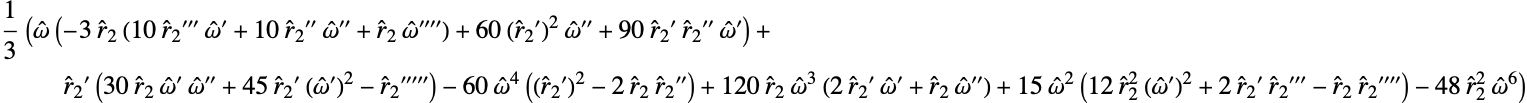

In [87]:
dEdtTemp = RHSEnegryLagrange[[1]] //. Fh5Replacement;
dEdt = Simplify[dEdtTemp/Subscript[\[Epsilon], G], Trig -> True];
dEdt // TraditionalForm

<span style="color:red">**NB:**</span> В файлах Binary.pdf и binary_catch1.pdf выводится <span style="color:green">**точно такие же**</span> выражения для правой части (dE/dt),
а именно $I_E = I_1\hat{\omega} + I_2\frac{\dot{r}}{r}$, где
$$
I_2 = 2\hat{r}_2 \left[ -40\hat{r}_2\hat{\omega}^3\hat{\omega}^{(1)} - 20\hat{\omega}^4\hat{r}_2^{(1)} + 5\hat{r}_2\hat{\omega}\hat{\omega}^{(3)} + 10\hat{r}_2\hat{\omega}^{(1)}\hat{\omega}^{(2)} + 10\hat{\omega}^2\hat{r}_2^{(3)} + 30\hat{\omega}\hat{\omega}^{(1)}\hat{r}_2^{(2)} + 20\hat{\omega}\hat{\omega}^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\hat{\omega}^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]
$$

In [89]:
I2 = 2 * Subscript[OverHat[r], 2][OverHat[t]] * (
    -40 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^3 * Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    - 20 * OverHat[\[Omega]][OverHat[t]]^4 *
    Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]]
    + 5 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]] * Derivative[3][OverHat[\[Omega]]][OverHat[t]]
    + 10 * Subscript[OverHat[r], 2][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]]
    + 10 * OverHat[\[Omega]][OverHat[t]]^2 *
    Derivative[3][Subscript[OverHat[r], 2]][OverHat[t]]
    + 30 * OverHat[\[Omega]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]]
    + 20 * OverHat[\[Omega]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]]
    + 15 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]]^2
    - (1/3) * Derivative[5][Subscript[OverHat[r], 2]][OverHat[t]]
);
Simplify[(I2*D[OverHat[r][OverHat[t]], OverHat[t]]/OverHat[r][OverHat[t]] + I1*OverHat[\[Omega]][OverHat[t]] /. ToR2Replacement) - dEdt]

0

# $I_J$, $I_E$

$$
\begin{align}
\tag{IJ}\
I_J &= \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\hat{\omega}^2\hat{\omega}^{(1)} - 5\hat{r}_2^{(1)}\hat{\omega}^{(3)} - 16\hat{r}_2\hat{\omega}^5 - 10\hat{r}_2^{(2)}\hat{\omega}^{(2)} + 60\hat{r}_2\hat{\omega}(\hat{\omega}^{(1)})^2
- 10\hat{r}_2^{(3)}\hat{\omega}^{(1)} + 40\hat{r}_2^{(2)}\hat{\omega}^3 - 5\hat{r}_2^{(4)}\hat{\omega} - \hat{r}_2\hat{\omega}^{(4)} + 40\hat{r}_2\hat{\omega}^2\hat{\omega}^{(2)} \right]
\\
\tag{IE}
I_E &= I_J\hat{\omega} + \hat{r}_2^{(1)} \left[ -40\hat{r}_2\hat{\omega}^3\hat{\omega}^{(1)} - 20\hat{\omega}^4\hat{r}_2^{(1)} + 5\hat{r}_2\hat{\omega}\hat{\omega}^{(3)} + 10\hat{r}_2\hat{\omega}^{(1)}\hat{\omega}^{(2)} + 10\hat{\omega}^2\hat{r}_2^{(3)} + 30\hat{\omega}\hat{\omega}^{(1)}\hat{r}_2^{(2)} + 20\hat{\omega}\hat{\omega}^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\hat{\omega}^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]
\end{align}
$$

Пусть $I_J$ и $I_E$ равны нулю.
Тогда и момент импульса и энергия сохраняются.

$\hat{J} = |\vec{\hat{r}} \times \vec{\hat{v}}| = |\vec{\hat{r}}_\infty \times \vec{\hat{v}}_\infty| = \hat{r}\hat{v}_\infty \sin(\phi)$

Так как $\phi = \pi/2$ на бесконечности, то $\hat{J} = b\hat{v}_\infty = u$,
то $u$ - безразмерная скорость на бесконечности.

Отсюда следует, что $\hat{\omega} = \frac{u}{\hat{r}_2}$

In [90]:
OmegaReplace2 = {
   OverHat[\[Omega]][OverHat[t]] -> u/Subscript[OverHat[r], 2][OverHat[t]],
   Derivative[n_][OverHat[\[Omega]]][OverHat[t]] :> u D[1/Subscript[OverHat[r], 2][OverHat[t]], {OverHat[t], n}]
};

FormBox[RowBox[{RowBox[{"-", RowBox[{FractionBox[RowBox[{"16", " ", 

 
>               SuperscriptBox["u", "6"]}], 

 
>             SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"]]}]}], "+", 

 
>        FractionBox[RowBox[{"40", " ", SuperscriptBox["u", "4"], " ", 

 
>           SuperscriptBox[RowBox[{"(", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], ")"}], 

 
>            "2"]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"]], "+", 

 
>        FractionBox[RowBox[{SuperscriptBox["u", "2"], " ", 

 
>           RowBox[{"(", RowBox[{RowBox[{"-", 

 
>                 RowBox[{"72", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                   SuperscriptBox[RowBox[{"(", 

 
>                      SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                       "′"], ")"}], "2"], " ", 

 
>                   SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"]}]}\

 
>   ], "+", RowBox[{"36", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"], 

 
>                 " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                  "′"], " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                   "2"], "′′′"]}], "+", 

 
>               RowBox[{"33", " ", SuperscriptBox[RowBox[{"(", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    ")"}], "4"]}], "+", 

 
>               RowBox[{"12", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", 

 
>                  "2"], " ", SuperscriptBox[RowBox[{"(", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                     "′′"], ")"}], "2"]}], "-", 

 
>               RowBox[{"12", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", 

 
>                  "3"], " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                   "2"], "′′′′"]}]}], ")"}]}], 

 
>         RowBox[{"3", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"]}]],\
 
>    "-", 
     RowBox[{FractionBox["1", "3"], " ", 

 
>          SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], " ", 

 
>          SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′′′"]}]}], 

 
>      TraditionalForm]
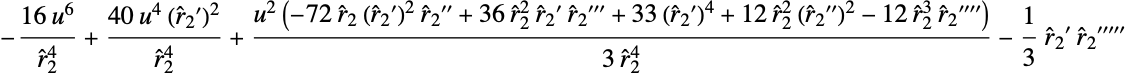

In [92]:
dEdtNoOmega = Collect[Simplify[dEdt //. OmegaReplace2], u];
dEdtNoOmega // TraditionalForm

Из сохранения энергии следует, что
$\hat{E} = \hat{E}_\infty = \frac{u^2}{2} = \left(\frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}\right)$

FormBox[RowBox[{"{", RowBox[{RowBox[{RowBox[{"-", "2"}], " ", 

 
>            SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                 SuperscriptBox["u", "2"]}], "+", 

 
>               RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    
            "-", SuperscriptBox["u", "2"]}]]}], ",", 

 
>          RowBox[{"2", " ", RowBox[{"(", 
           RowBox[{FractionBox["1", 

 
>                 SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]], "+", 

 
>                SuperscriptBox["u", "2"]}], ")"}]}], ",", 

 
>          FractionBox[RowBox[{"2", " ", 

 
>             SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                  SuperscriptBox["u", "2"]}], "+", 

 
>                RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                    "2"]]}], "-", SuperscriptBox["u", "2"]}]]}], 

 
>           SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"3", "/", "2"}]]], 

 
>          ",", FractionBox[RowBox[{"2", " ", 

 
>             RowBox[{"(", RowBox[{RowBox[{"2", " ", 

 
>                   SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                   SuperscriptBox["u", "2"]}], "+", 

 
>                 RowBox[{"5", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                     "2"]]}], "-", RowBox[{"3", " ", SuperscriptBox["u", "2"]}]}],\
 
>    ")"}\
]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"5", "/",\
 
>    "2"}]]], ",", 
       FractionBox[RowBox[{"2", " ", 

 
>             SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                  SuperscriptBox["u", "2"]}], "+", 

 
>                RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                    "2"]]}], "-", SuperscriptBox["u", "2"]}]], " ", 

 
>             RowBox[{"(", RowBox[{RowBox[{"6", " ", 

 
>                   SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                   SuperscriptBox["u", "2"]}], "+", 

 
>                 RowBox[{"20", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                     "2"]]}], "-", RowBox[{"15", " ", SuperscriptBox["u", "2"]}]}],\
 
>    ")"}\
]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"7", "/",\
 
>    "2"}]]]}], "}"}]\
, TraditionalForm]
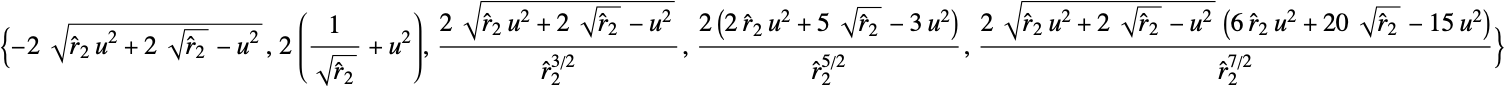

In [98]:
eq = Energy - u^2/2 //. Flatten[{
   ToR2Replacement,
   OmegaReplace2,
   D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]]^2 -> x^2
}];

sol = Solve[eq == 0, x][[1]];

replacementRule = D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]] :> x /. sol[[1]];

(* Рекурсивно вычисляем производные *)
dr2 = NestList[
   Simplify[D[#, OverHat[t]] /. replacementRule] &,
   x /. sol[[1]],
   4
];

dr2 // TraditionalForm

FormBox[RowBox[{FractionBox[RowBox[{"8", " ", SuperscriptBox["u", "4"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"3", "/", "2"}]]],\
 
>    "-", 
     FractionBox[RowBox[{"100", " ", SuperscriptBox["u", "4"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"7", "/", "2"}]]],\
 
>    "+", 
     FractionBox[RowBox[{"4", " ", 

 
>           RowBox[{"(", RowBox[{RowBox[{"51", " ", SuperscriptBox["u", "4"]}], "+", 

 
>               "40"}], ")"}]}], RowBox[{"3", " ", 

 
>           SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"5", "/", "2"}]]}]],\
 
>    
     "+", FractionBox[RowBox[{"128", " ", SuperscriptBox["u", "2"]}], 

 
>         RowBox[{"3", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"]}]],\
 
>    "+", 
     FractionBox[RowBox[{"400", " ", SuperscriptBox["u", "2"]}], 

 
>         RowBox[{"3", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", "3"]}]]}], 

 
>      TraditionalForm]
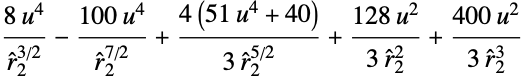

In [100]:
dEdtNoOmegaFinal = Fold[ (* Последовательно применяем замены *)
  Simplify[#1 /.
    D[Subscript[OverHat[r], 2][OverHat[t]], {OverHat[t], #2}] -> dr2[[#2]]] &,
  dEdtNoOmega,
  Range[5]
];

Collect[dEdtNoOmegaFinal, Subscript[OverHat[r], 2][OverHat[t]]] // TraditionalForm

In [101]:
rMin[u_] := (Sqrt[1 + u^4] - 1)/u^2;

9                      6                       3
            -45 u                   75 u                    40 u
(8 (---------------------- + -------------------- + ---------------------- + 
                    4  5/2                   4  2                   4  3/2
    (-1 + Sqrt[1 + u ])      (-1 + Sqrt[1 + u ])    (-1 + Sqrt[1 + u ])
 
                    7                         5
                51 u                      18 u                               4
>       ---------------------- + ----------------------- + 48 (1 + Sqrt[1 + u ]))) / 9
                        4  3/2                       4
        (-1 + Sqrt[1 + u ])      Sqrt[-1 + Sqrt[1 + u ]]
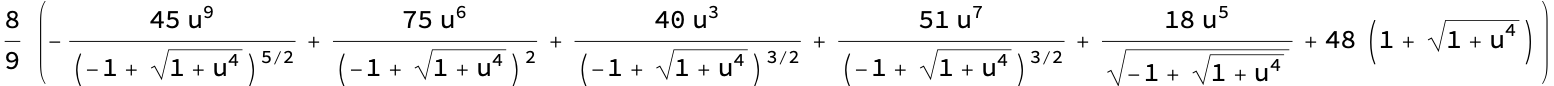

In [102]:
deltaE = Simplify[Integrate[dEdtNoOmegaFinal, {Subscript[OverHat[r], 2][OverHat[t]], rMin[u], Infinity}, Assumptions -> {u ∈ Reals, u > 0}]]

In [ ]:
(* Reduce[2*deltaE*Subscript[\[Epsilon], G] >= -u^2/2] *)

: 